In [15]:
!pip install yfinance
!pip install yfinance --upgrade
!pip install pandas_datareader

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: yfinance in /home/george/.local/lib/python3.6/site-packages (0.1.54)
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable


In [1]:
import numpy as np
import pandas as pd

import statsmodels
from statsmodels.tsa.stattools import coint
# just set the seed for the random number generator
np.random.seed(107)

import matplotlib.pyplot as plt

In [2]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [40]:
from backtester.dataSource.yahoo_data_source import YahooStockDataSource
from datetime import datetime
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import datetime
import scipy.optimize as optimization



instid = ['ETH-USD','BTC-USD','BAT-USD','LTC-USD','XMR-USD','BCH-USD']

start_date = '12/01/2017'
end_date = '12/01/2019'
#cachedFolderName = 'yahooData/'
#dataSetId = 'testPairsTrading'

def download_data(stocks):
    data = web.DataReader(stocks,data_source='yahoo',start=start_date,end=end_date)['Adj Close']
    return data

data = download_data(instid)

In [41]:
data.head(3)

Symbols,BAT-USD,BCH-USD,BTC-USD,ETH-USD,LTC-USD,XMR-USD
Date,,,,,,
2017-12-01,0.176916,1462.680054,10975.599609,466.540009,99.003700,190.938004
2017-12-02,0.169221,1434.979980,11074.599609,463.449005,100.283997,203.033997
2017-12-03,0.170244,1559.930054,11323.200195,465.852997,101.263000,200.050995


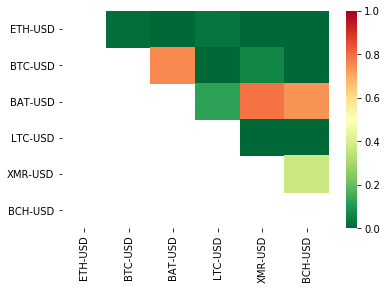

[('BAT-USD', 'BCH-USD'), ('BAT-USD', 'BTC-USD'), ('BAT-USD', 'ETH-USD'), ('BAT-USD', 'LTC-USD'), ('BAT-USD', 'XMR-USD'), ('BCH-USD', 'ETH-USD'), ('BCH-USD', 'XMR-USD'), ('ETH-USD', 'LTC-USD'), ('ETH-USD', 'XMR-USD')]


In [44]:
scores, pvalues, pairs = find_cointegrated_pairs(data)
import seaborn
m = [0,0.2,0.4,0.6,0.8,1]
seaborn.heatmap(pvalues, xticklabels=instid, 
                yticklabels=instid, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.98)
                )
plt.show()
print(pairs)

4.342732461664387e-09


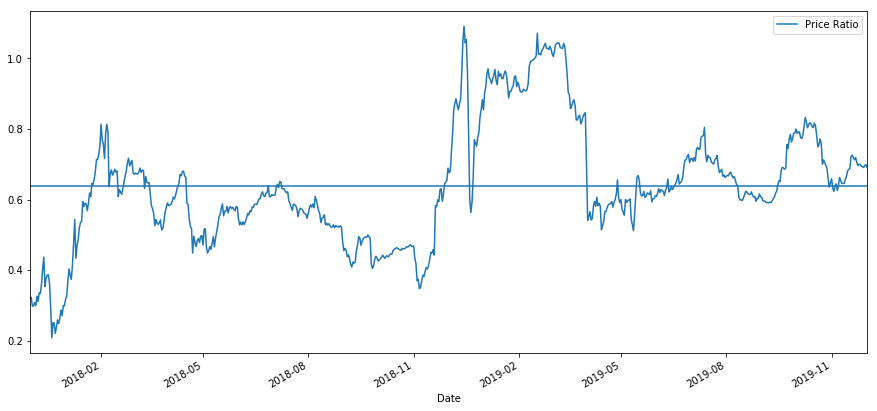

In [77]:
S1 = data['ETH-USD']
S2 = data['BCH-USD']
score, pvalue, _ = coint(S1, S2)
print(pvalue)
ratios = S1 / S2
ratios.plot(figsize=(15,7))
plt.axhline(ratios.mean())
plt.legend(['Price Ratio'])
plt.show()

In [78]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

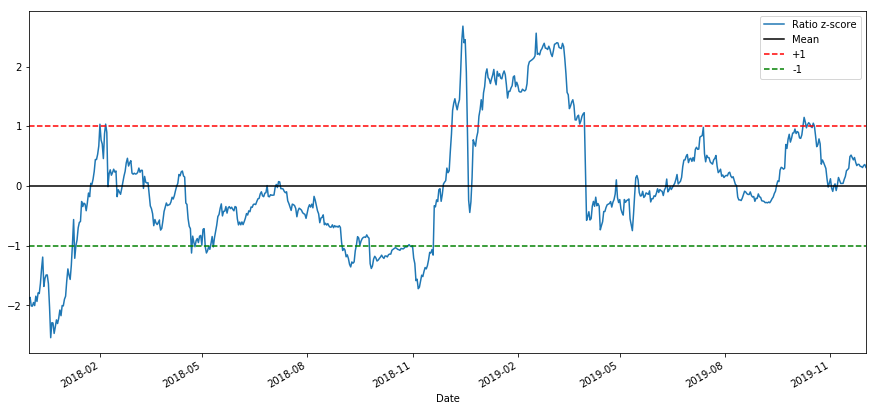

In [79]:
zscore(ratios).plot(figsize=(15,7))
plt.axhline(zscore(ratios).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Ratio z-score', 'Mean', '+1', '-1'])
plt.show()

In [80]:
ratios = data['ETH-USD'] / data['BCH-USD']
print(len(ratios))
train = ratios[:512]
test = ratios[512:]


732


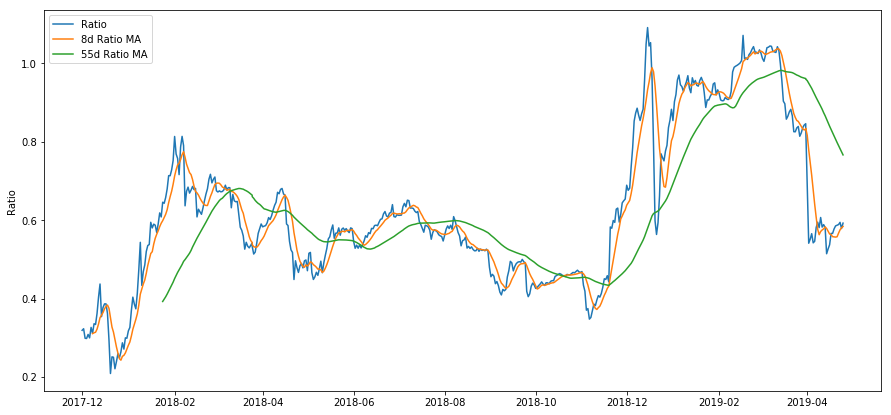

In [81]:
ratios_mavg8 = train.rolling(window=8,
                               center=False).mean()

ratios_mavg55 = train.rolling(window=55,
                               center=False).mean()

std_55 = train.rolling(window=60,
                        center=False).std()

zscore_55_5 = (ratios_mavg8 - ratios_mavg55)/std_55
plt.figure(figsize=(15,7))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg8.index, ratios_mavg8.values)
plt.plot(ratios_mavg55.index, ratios_mavg55.values)

plt.legend(['Ratio','8d Ratio MA', '55d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

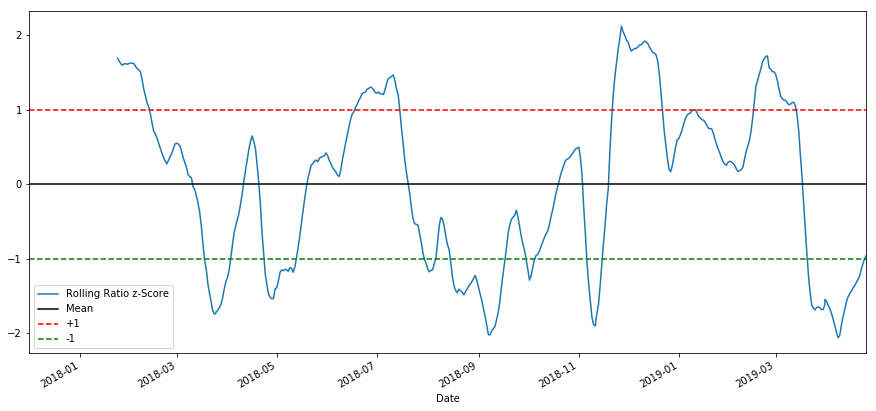

In [82]:
# Take a rolling 60 day standard deviation
std_55 = train.rolling(window=55,center=False).std()
std_55.name = 'std 55d'

# Compute the z score for each day
zscore_55_5 = (ratios_mavg8 - ratios_mavg55)/std_55
zscore_55_5.name = 'z-score'

plt.figure(figsize=(15,7))
zscore_55_5.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

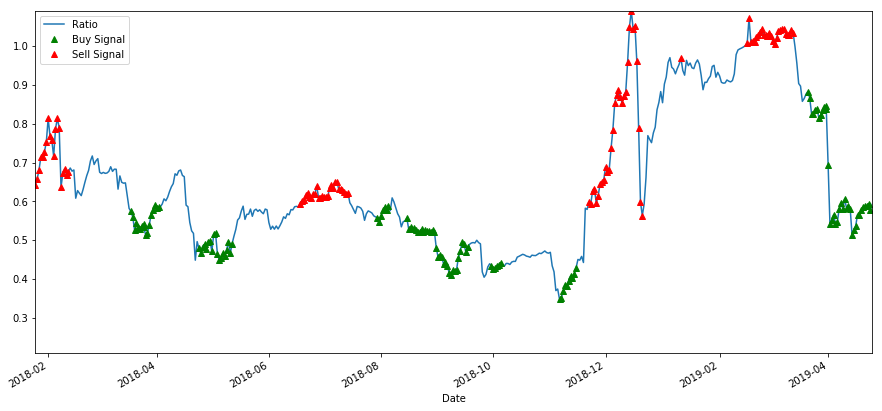

In [83]:
# Plot the ratios and buy and sell signals from z score
plt.figure(figsize=(15,7))

train[55:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_55_5>-1] = 0
sell[zscore_55_5<1] = 0
buy[55:].plot(color='g', linestyle='None', marker='^')
sell[55:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,ratios.min(),ratios.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

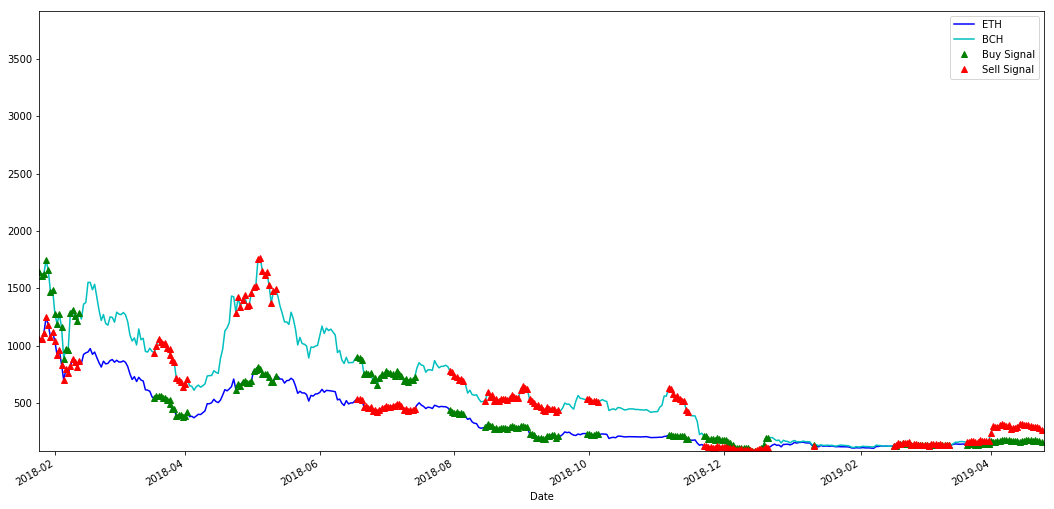

In [84]:
# Plot the prices and buy and sell signals from z score
plt.figure(figsize=(18,9))
S1 = data['ETH-USD'].iloc[:512]
S2 = data['BCH-USD'].iloc[:512]

S1[55:].plot(color='b')
S2[55:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When buying the ratio, buy S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]
# When selling the ratio, sell S1 and buy S2 
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[55:].plot(color='g', linestyle='None', marker='^')
sellR[55:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,min(S1.min(),S2.min()),max(S1.max(),S2.max())))

plt.legend(['ETH','BCH', 'Buy Signal', 'Sell Signal'])
plt.show()

In [85]:
# Trade using a simple strategy
def trade(S1, S2, window1, window2):
    
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] > 1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
        # Buy long if the z-score is < 1
        elif zscore[i] < -1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.5:
            money += countS1*S1[i] - S2[i] * countS2
            count = 0
            
    return money

trade(data['ETH-USD'].iloc[:512], data['BCH-USD'].iloc[:512], 55, 8)


725483.5274147041

In [86]:
trade(data['ETH-USD'].iloc[512:], data['BCH-USD'].iloc[512:], 55, 8)

98691.2185241665

In [88]:
# Find the window length 0-254 
# that gives the highest returns using this strategy
length_scores = [trade(data['ETH-USD'].iloc[:512], 
                data['BCH-USD'].iloc[:512], l, 5) 
                for l in range(255)]
best_length = np.argmax(length_scores)
print ('Best window length:', best_length)

Best window length: 11


In [89]:
# Find the returns for test data
# using what we think is the best window length
length_scores2 = [trade(data['ETH-USD'].iloc[512:], 
                  data['BCH-USD'].iloc[512:],l,5) 
                  for l in range(255)]
print (best_length, 'day window:', length_scores2[best_length])

# Find the best window length based on this dataset, 
# and the returns using this window length
best_length2 = np.argmax(length_scores2)
print (best_length2, 'day window:', length_scores2[best_length2])

11 day window: 58289.84183987949
38 day window: 140860.31839859113


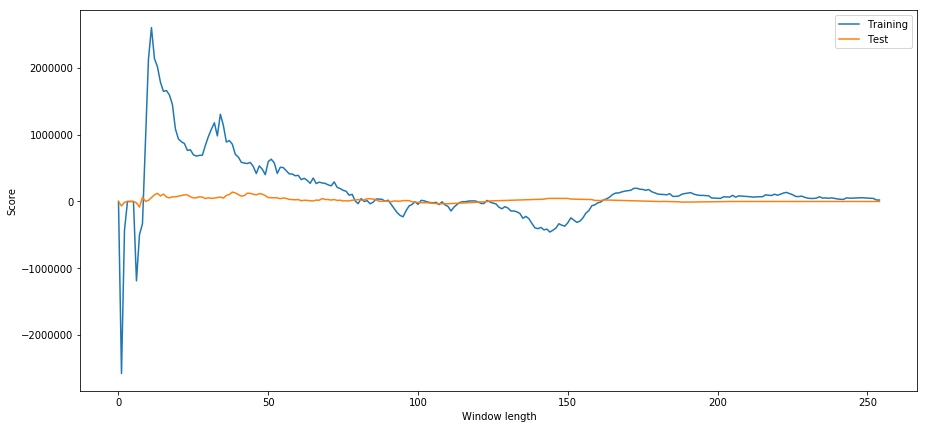

In [90]:
plt.figure(figsize=(15,7))
plt.plot(length_scores)
plt.plot(length_scores2)
plt.xlabel('Window length')
plt.ylabel('Score')
plt.legend(['Training', 'Test'])
plt.show()